In [134]:
import matplotlib.pyplot as plt
import numpy as np
import imutils
import cv2
from os.path import join

#function to add contrast to the image, returns image with better contrast
def add_contrast(image):
    lab = cv2.cvtColor(image, cv2.COLOR_BGR2LAB)
    l, a, b = cv2.split(lab)
    clahe = cv2.createCLAHE(clipLimit=3.0, tileGridSize=(8,8))
    cl = clahe.apply(l)
    limg = cv2.merge((cl, a,b))
    return cv2.cvtColor(limg, cv2.COLOR_LAB2BGR)

def read_image(image):
    img = cv2.imread(image)
    RGB_img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    return RGB_img

def display_image(image):
    plt.imshow(image, cmap='gray')
    plt.show()

def resize_image(image, size=(800,800)):
    return cv2.resize(image, size)

def blur_image(image):
    return cv2.GaussianBlur(image, (11, 11), 0)

def combine(image, contrast=True, resize=True, blur=False):
    if contrast:
        img = add_contrast(image)
    if resize:
        img = resize_image(img)
    if blur:
        img = blur_image(img)

    return img

def gray_image(image):
    return cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)

def convert_color(image, toRGB=True):
    return cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

def thresh_image(image, threshold=185):
    return cv2.threshold(image, threshold, 255, cv2.THRESH_BINARY)[1]

def save_image(directory, image, name):
    path = join(directory, '{0}'.format(name)+'.jpg')
    cv2.imwrite(path, image)
    
def grab_contours_and_sort_by_area(image, threshold=185, all=False):
    
    image_grayed = gray_image(image)
    image_threshed = thresh_image(image_grayed, threshold=threshold)
    
    if all:
        contours = cv2.findContours(image_threshed.copy(), cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    else: 
        contours = cv2.findContours(image_threshed.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    contours = imutils.grab_contours(contours)
    
    return sorted(contours, key=cv2.contourArea, reverse=True)

def draw_contour(image, contour):
    contour_image = cv2.drawContours(image, contour, -1, (255,0,0), 3)
    
    return contour_image

def add_images(image1, image2, hor=True):
    if hor:
        img = np.concatenate((image1, image2), axis=1)
    else:
        img = np.concatenate((image1, image2), axis=0)
    return img

def create_prediction_folders(number):
    folder = 'test/predict{0}'.format(number)
    if not isdir(folder):
        makedirs(folder)
        makedirs('{0}/predict'.format(folder))
    return folder

In [98]:
imgname = 'test5.jpg'

In [99]:
img = read_image(imgname)

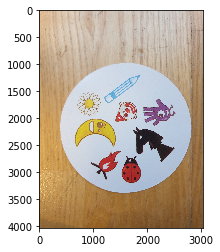

In [100]:
display_image(img)

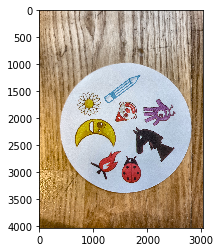

In [101]:
img_contrasted = add_contrast(img)
display_image(img_contrasted)

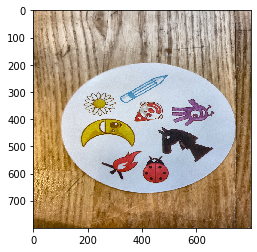

In [102]:
img_contrasted_resized = resize_image(img_contrasted)
display_image(img_contrasted_resized)

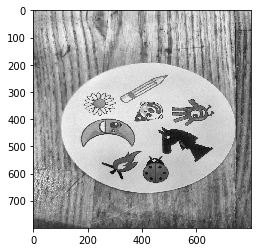

In [103]:
img_contrasted_resized_grayed = gray_image(img_contrasted_resized)
display_image(img_contrasted_resized_grayed)

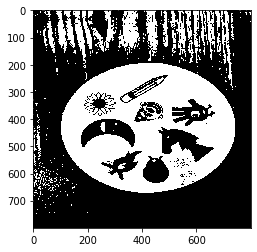

In [104]:
img_contrasted_resized_grayed_threshed = thresh_image(img_contrasted_resized_grayed)
display_image(img_contrasted_resized_grayed_threshed)

In [144]:
contours = grab_contours_and_sort_by_area(img_contrasted_resized)

In [145]:
biggest_contour = contours[0]
biggest_contour

array([[[431, 200]],

       [[428, 203]],

       [[427, 202]],

       ...,

       [[436, 202]],

       [[435, 202]],

       [[434, 203]]], dtype=int32)

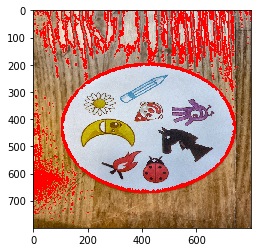

In [148]:
img_with_biggest_contour = draw_contour(img_contrasted_resized, biggest_contour)
display_image(img_with_biggest_contour)

In [149]:
# create mask with the biggest contour
mask = np.zeros(img_contrasted_resized_grayed.shape,np.uint8)
mask = cv2.drawContours(mask, [biggest_contour], -1, 255, cv2.FILLED)

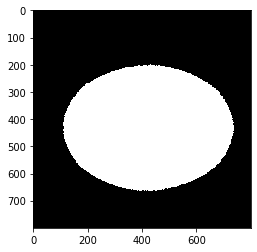

In [150]:
display_image(mask)

In [151]:
mask.shape

(800, 800)

In [152]:
# card in foreground
fg_masked = cv2.bitwise_and(img_contrasted_resized, img_contrasted_resized, mask=mask)

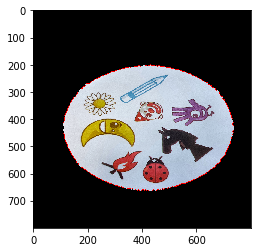

In [153]:
display_image(fg_masked)

In [154]:
# white background (use inverted mask)
inverted_mask = cv2.bitwise_not(mask)
bk = np.full(img_contrasted_resized.shape, 255, dtype=np.uint8)
bk_masked = cv2.bitwise_and(bk, bk, mask=inverted_mask)

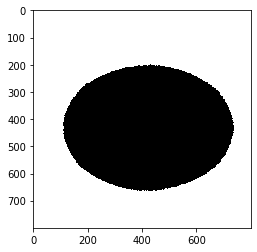

In [155]:
display_image(bk_masked)

In [156]:
# combine back- and foreground
final = cv2.bitwise_or(fg_masked, bk_masked)

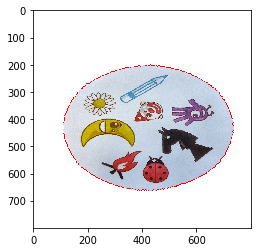

In [157]:
display_image(final)

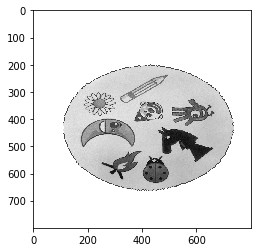

In [158]:
final_grayed = gray_image(final)
display_image(final_grayed)

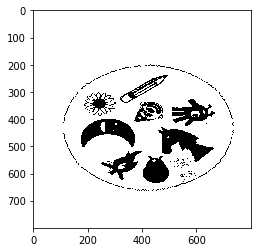

In [159]:
final_grayed_threshed = thresh_image(final_grayed)
display_image(final_grayed_threshed)

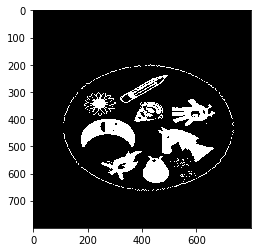

In [160]:
final_grayed_threshed = cv2.bitwise_not(final_grayed_threshed)
display_image(final_grayed_threshed)

In [161]:
cnts = cv2.findContours(final_grayed_threshed.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
cnts = imutils.grab_contours(cnts)
cnts = sorted(cnts, key=cv2.contourArea, reverse=True)[:10]

In [162]:
len(cnts)

10

In [164]:
# handle each contour
i = 0
for c in cnts:
    if cv2.contourArea(c) > 1000:
        # draw mask, keep contour
        mask = np.zeros(final_grayed.shape, np.uint8)
        mask = cv2.drawContours(mask, [c], -1, 255, cv2.FILLED)
        # white background
        fg_masked = cv2.bitwise_and(final, final, mask=mask)
        mask = cv2.bitwise_not(mask)
        bk = np.full(final.shape, 255, dtype=np.uint8)
        bk_masked = cv2.bitwise_and(bk, bk, mask=mask)
        finalcont = cv2.bitwise_or(fg_masked, bk_masked)
        # bounding rectangle around contour
        output = finalcont.copy()
        x,y,w,h = cv2.boundingRect(c)
        # squares io rectangles
        if w < h:
            x += int((w-h)/2)
            w = h
        else:
            y += int((h-w)/2)
            h = w
        # take out the square with the symbol
        roi = finalcont[y:y+h, x:x+w]
        roi = cv2.resize(roi, (400,400))
        # save the symbol
        cv2.imwrite(f"{imgname}_icon{i}.jpg", roi)
        i += 1